In [1]:
import pandas as pd
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import os
import shutil
import re
import pickle as pkl

In [2]:
nonquasi_list = ['Pseudo','Neutral','Adaptive','Neutral_dom','Adaptive_dom','quasi_stablespace20']
quasi_list = [
    'quasi_dom',
    'quasi_env2','quasi_env5','quasi_env10','quasi_env20',
    'quasi_int2','quasi_int25','quasi_int100','quasi_int200',
    'quasi_pop500','quasi_pop1000','quasi_pop5000','quasi_pop10000','quasi_pop50000',
    'quasi_neufrac0.05','quasi_neufrac0.15','quasi_neufrac0.2','quasi_neufrac0.25',
    'quasi_lambda2','quasi_lambda4','quasi_lambda6','quasi_lambda8','quasi_lambda10',
    'quasi_AP0.15','quasi_AP0.35','quasi_AP0.45','quasi_AP0.5'
]

In [4]:
rcParams_dict = {
    'xtick.bottom': False,
    'axes.spines.top': False,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'patch.edgecolor':'k',
    'patch.force_edgecolor': True,
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

color_list = ['C0','C1','C2','C3','C4','C5','C6','tan','C8','C9','yellow','lime']
color_list2 = ['dimgrey','white','lightgrey']
mut_type_list = ['Beneficial','Neutral','Deleterious']
flierprops = dict(marker='.', markerfacecolor='black', markersize=2,
                  linestyle='none')

In [3]:
with open('./data/Allele_spectrum_v3.pkl','rb') as file:
    spectrum_final_dict = pkl.load(file)

summary_df = pd.read_csv('./data/SLiM_summary_raw.csv')

plt_df = pd.read_csv('./data/Simulation_summary.csv')

/tmp/ipykernel_392294/613452490.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


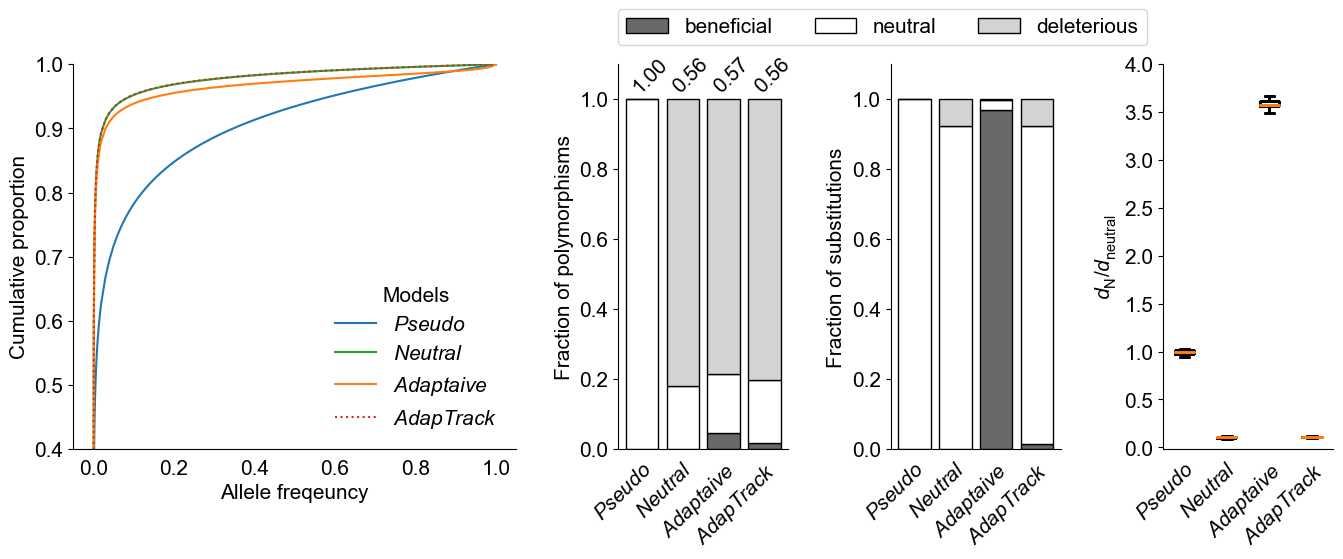

In [14]:
# Figure 2 a-d

line_type_dict = {
    'Pseudo':'-',
    'Neutral':'-',
    'Adaptive':'-',
    'quasi_pop10000':':'
}
color_list = ['C0','C2','C1','C3']

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6,)
ax1 = fig.add_subplot(gs[0, 0:2],)
ax2 = fig.add_subplot(gs[0, 2])
ax3= fig.add_subplot(gs[0, 3])
ax4= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\it{Pseudo}$','$\it{Neutral}$','$\it{Adaptaive}$','$\it{AdapTrack}$']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for k,version in enumerate(['Pseudo','Neutral','Adaptive','quasi_pop10000']):
    ax1.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),
             ls=line_type_dict[version],label=type_list[k],color=color_list[k])
ax1.legend(title='Models',framealpha=0)
ax1.set_xlabel('Allele freqeuncy',fontsize=15)
ax1.set_ylabel('Cumulative proportion',fontsize=15)
ax1.set_ylim(0.4,1)

for idx,i in enumerate([0,1,2,18]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax2.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[0,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax2.text(
        x=idx+0.2,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45
    )


ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax2.set_ylabel('Fraction of polymorphisms')
ax2.legend(loc=[0,1.05], ncol=3)
ax2.set_ylim(0,1.1)

ax3.set_xticks([0,1,2,3])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax3.set_ylabel('Fraction of substitutions')
ax3.set_ylim(0,1.1)

for rep in range(1,31):
    ax4.boxplot(
        plt_df.loc[[0,1,2,18],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        flierprops = flierprops
    )
ax4.set_xticks([1,2,3,4])
ax4.set_ylim(-0.02,4)
ax4.set_xlim(0.5,4.5)
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax4.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$')

plt.tight_layout()
#plt.savefig(f'./Figures/Fig2_1.pdf',bbox_inches='tight')

/tmp/ipykernel_392294/3210853143.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


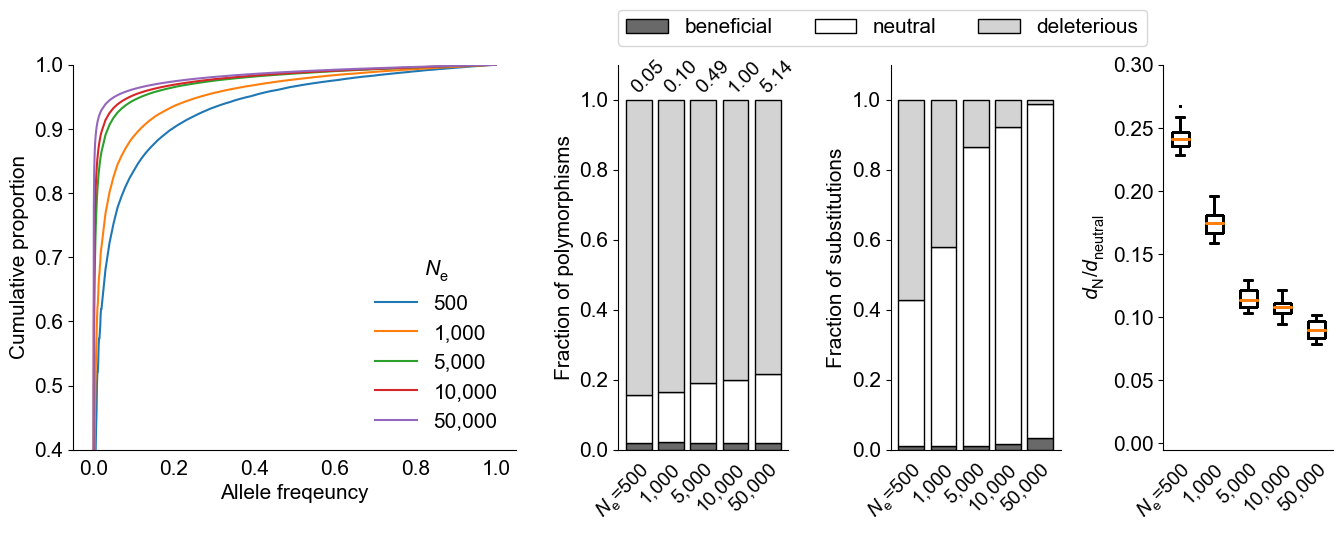

In [15]:
# Figure 2 e-h

label_dict = {
    'quasi_pop500':'500',
    'quasi_pop1000':'1,000',
    'quasi_pop5000':'5,000',
    'quasi_pop10000':'10,000',
    'quasi_pop50000':'50,000'
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
ax3= fig.add_subplot(gs[0, 3])
ax4= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\mathit{N}_e$=500','1,000','5,000','10,000','50,000']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_pop500','quasi_pop1000','quasi_pop5000','quasi_pop10000','quasi_pop50000']:
    ax1.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),
             label=label_dict[version])
ax1.legend(title='$\mathit{N}_e$',framealpha=0)
ax1.set_xlabel('Allele freqeuncy',fontsize=15)
ax1.set_ylabel('Cumulative proportion',fontsize=15)
ax1.set_ylim(0.4,1)

for idx,i in enumerate([15,16,17,18,19]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax2.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax2.text(
        x=idx+0.3,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,size=14
    )

ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(
    type_list, rotation = 45,size=14,
    ha='right', rotation_mode='anchor')
ax2.set_ylabel('Fraction of polymorphisms')
ax2.legend(loc=[0,1.05], ncol=3)
ax2.set_ylim(0,1.1)

ax3.set_xticks([0,1,2,3,4])
ax3.set_xticklabels(
    type_list, rotation = 45,size=14,
    ha='right', rotation_mode='anchor')
ax3.set_ylabel('Fraction of substitutions')
ax3.set_ylim(0,1.1)

for rep in range(1,31):
    ax4.boxplot(
        plt_df.loc[[15,16,17,18,19],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        flierprops=flierprops
    )
ax4.set_xticks([1,2,3,4,5])
ax4.set_ylim(-0.005,0.3)
ax4.set_xlim(0.5,5.5)
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=14)
ax4.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$')

plt.tight_layout()
#plt.savefig(f'./Figures/Fig2_2.pdf',bbox_inches='tight')

/tmp/ipykernel_392294/1036695039.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


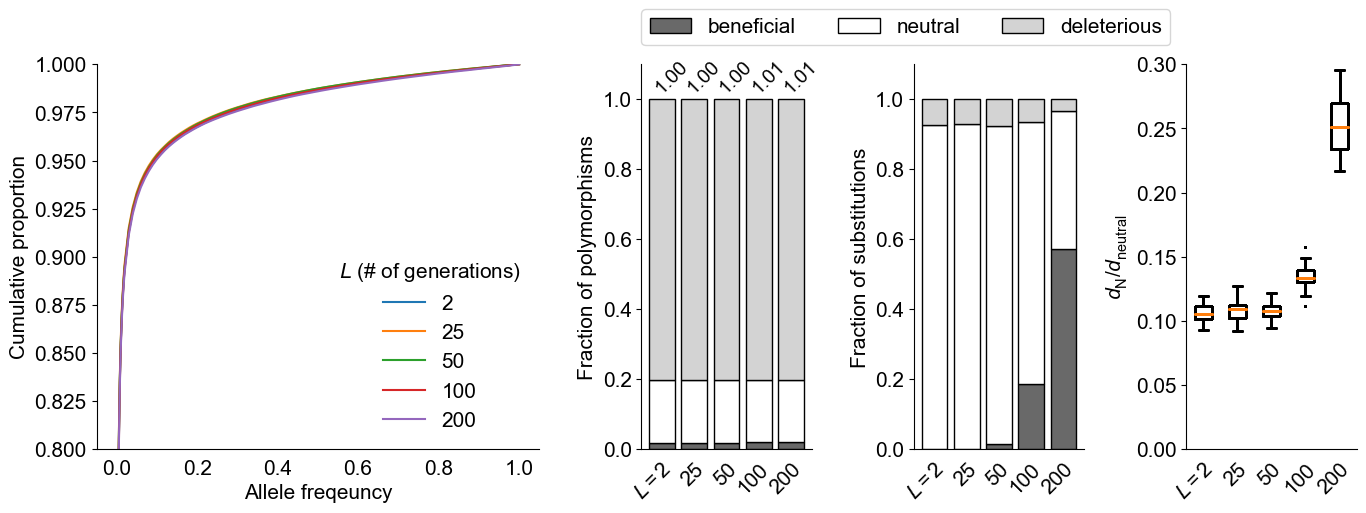

In [16]:
# Figure 2 i-l

label_dict = {
    'quasi_int2':'2',
    'quasi_int25':'25',
    'quasi_pop10000':'50',
    'quasi_int100':'100',
    'quasi_int200':'200'
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0:2],)
ax2 = fig.add_subplot(gs[0, 2])
ax3= fig.add_subplot(gs[0, 3])
ax4= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\mathit{L}=2$','25','50','100','200']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_int2','quasi_int25','quasi_pop10000','quasi_int100','quasi_int200']:
    ax1.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax1.legend(title='$\mathit{L}$ (# of generations)',framealpha=0)
ax1.set_xlabel('Allele freqeuncy',fontsize=15)
ax1.set_ylabel('Cumulative proportion',fontsize=15)
ax1.set_ylim(0.8,1)

for idx,i in enumerate([11,12,18,13,14]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax2.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax2.text(
        x=idx+0.3,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,size=14
    )

ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax2.set_ylabel('Fraction of polymorphisms')
ax2.legend(loc=[0,1.05], ncol=3)
ax2.set_ylim(0,1.1)

ax3.set_xticks([0,1,2,3,4])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax3.set_ylabel('Fraction of substitutions')
ax3.set_ylim(0,1.1)

for rep in range(1,31):
    ax4.boxplot(
        plt_df.loc[[11,12,18,13,14],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        flierprops = flierprops
    )
ax4.set_xticks([1,2,3,4,5])
ax4.set_ylim(0,0.3)
ax4.set_xlim(0.5,5.5)
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax4.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$')

plt.tight_layout()
#plt.savefig(f'./Figures/Fig2_3.pdf',bbox_inches='tight')

/tmp/ipykernel_392294/58945062.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


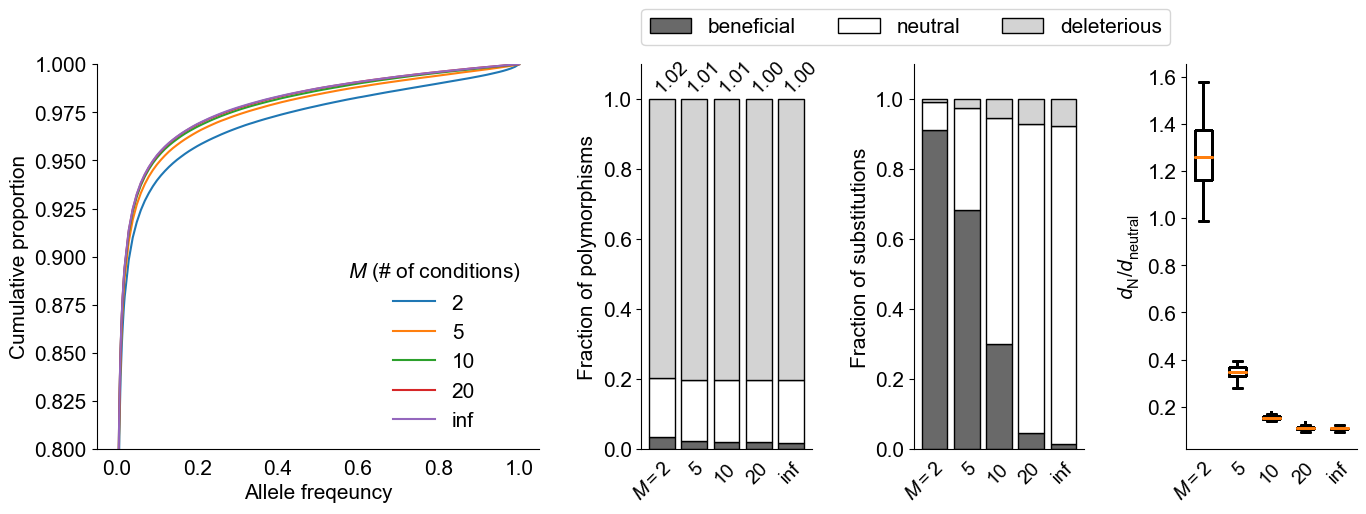

In [17]:
# Figure 2 m-p

label_dict = {
    'quasi_env2':'2',
    'quasi_env5':'5',
    'quasi_env10':'10',
    'quasi_env20':'20',
    'quasi_pop10000':'inf'
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
ax3= fig.add_subplot(gs[0, 3])
ax4= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\mathit{M}=2$','5','10','20','inf']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_env2','quasi_env5','quasi_env10','quasi_env20','quasi_pop10000']:
    ax1.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax1.legend(title='$\mathit{M}$ (# of conditions)',framealpha=0)
ax1.set_xlabel('Allele freqeuncy',fontsize=15)
ax1.set_ylabel('Cumulative proportion',fontsize=15)
ax1.set_ylim(0.8,1)

for idx,i in enumerate([7,8,9,10,18]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax2.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax2.text(
        x=idx+0.3,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,size=14
    )

ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=14)
ax2.set_ylabel('Fraction of polymorphisms')
ax2.legend(loc=[0,1.05], ncol=3)
ax2.set_ylim(0,1.1)

ax3.set_xticks([0,1,2,3,4])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=14)
ax3.set_ylabel('Fraction of substitutions')
ax3.set_ylim(0,1.1)

for rep in range(1,31):
    ax4.boxplot(
        plt_df.loc[[7,8,9,10,18],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        flierprops = flierprops
    )
ax4.set_xticks([1,2,3,4,5])
#ax4.set_ylim(0.05,0.15)
ax4.set_xlim(0.5,5.5)
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=14)
ax4.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$')

plt.tight_layout()
#plt.savefig(f'./Figures/Fig2_4.pdf',bbox_inches='tight')

/tmp/ipykernel_392294/4047525988.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


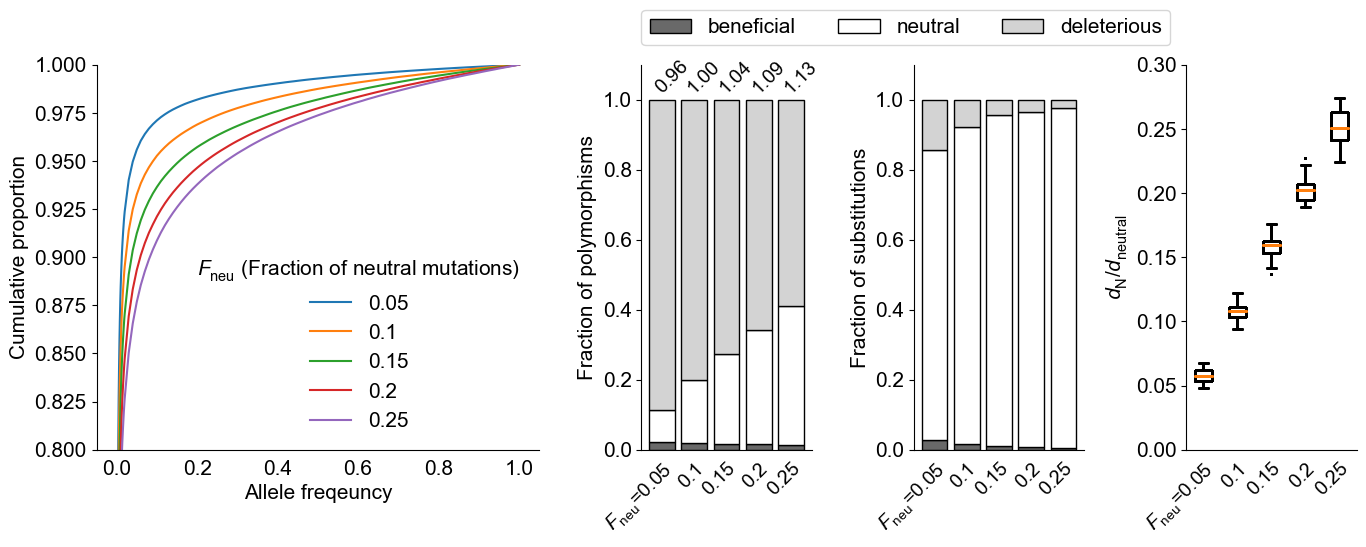

In [18]:
# Figure S3 a-d

label_dict = {
    'quasi_neufrac0.05':'0.05',
    'quasi_pop10000':'0.1',
    'quasi_neufrac0.15':'0.15',
    'quasi_neufrac0.2':'0.2',
    'quasi_neufrac0.25':'0.25',
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
ax3= fig.add_subplot(gs[0, 3])
ax4= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\mathit{F}_{neu}$=0.05','0.1','0.15','0.2','0.25']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_neufrac0.05','quasi_pop10000','quasi_neufrac0.15','quasi_neufrac0.2','quasi_neufrac0.25']:
    ax1.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax1.legend(title='$\mathit{F}_{neu}$ (Fraction of neutral mutations)',framealpha=0)
ax1.set_xlabel('Allele freqeuncy',fontsize=15)
ax1.set_ylabel('Cumulative proportion',fontsize=15)
ax1.set_ylim(0.8,1)

for idx,i in enumerate([20,18,21,22,23]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax2.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax2.text(
        x=idx+0.3,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,fontsize=14
    )

ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',fontsize=14)
ax2.set_ylabel('Fraction of polymorphisms')
ax2.legend(loc=[0,1.05], ncol=3)
ax2.set_ylim(0,1.1)

ax3.set_xticks([0,1,2,3,4])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',fontsize=14)
ax3.set_ylabel('Fraction of substitutions')
ax3.set_ylim(0,1.1)

for rep in range(1,31):
    ax4.boxplot(
        plt_df.loc[[20,18,21,22,23],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        flierprops = flierprops
    )
ax4.set_xticks([1,2,3,4,5])
ax4.set_ylim(0,0.3)
ax4.set_xlim(0.5,5.5)
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',fontsize=14)
ax4.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$')

plt.tight_layout()
#plt.savefig(f'./Figures/FigS3_1.pdf',bbox_inches='tight')

/tmp/ipykernel_392294/4119592052.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


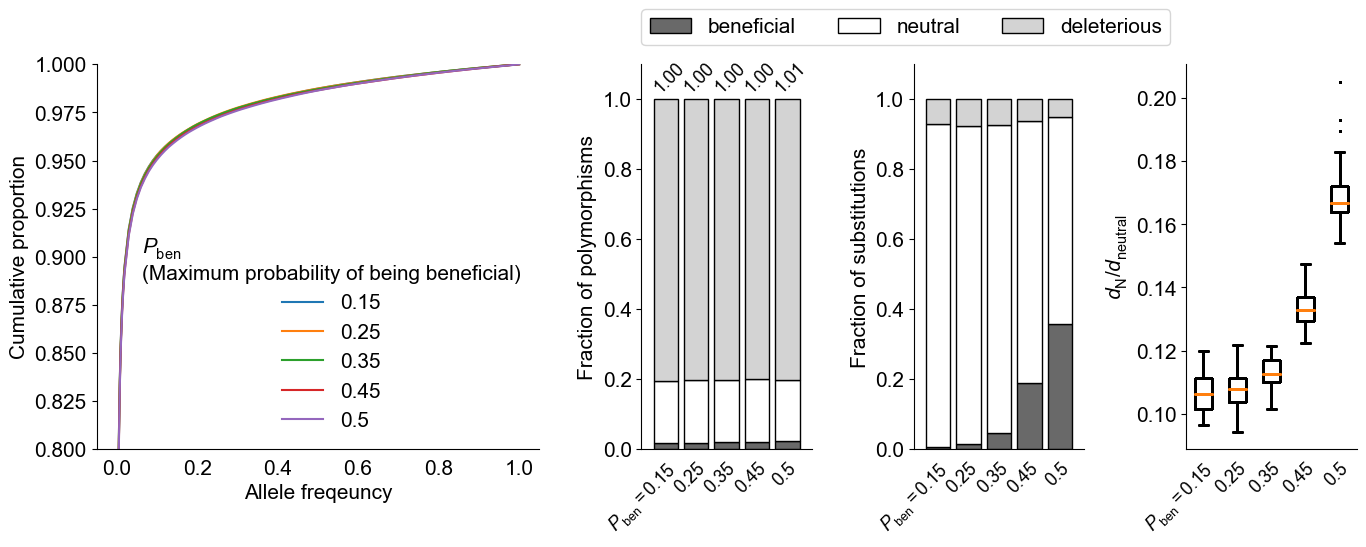

In [19]:
# Figure S3 e-h

meanORinst = 'inst'
label_dict = {
    'quasi_AP0.15':'0.15',
    'quasi_pop10000':'0.25',
    'quasi_AP0.35':'0.35',
    'quasi_AP0.45':'0.45',
    'quasi_AP0.5':'0.5',
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
ax3= fig.add_subplot(gs[0, 3])
ax4= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\mathit{P}_{ben}=0.15$','0.25','0.35','0.45','0.5']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_AP0.15','quasi_pop10000','quasi_AP0.35','quasi_AP0.45','quasi_AP0.5']:
    ax1.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax1.legend(title='$\mathit{P}_{ben}$ \n(Maximum probability of being beneficial)',framealpha=0)
ax1.set_xlabel('Allele freqeuncy',fontsize=15)
ax1.set_ylabel('Cumulative proportion',fontsize=15)
ax1.set_ylim(0.8,1)

for idx,i in enumerate([29,18,30,31,32]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax2.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax2.text(
        x=idx+0.1,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,size=13
    )
    
ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax2.set_ylabel('Fraction of polymorphisms')
ax2.legend(loc=[0,1.05], ncol=3)
ax2.set_ylim(0,1.1)
ax2.set_xlim(-0.8,4.8)

ax3.set_xticks([0,1,2,3,4])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax3.set_ylabel('Fraction of substitutions')
ax3.set_ylim(0,1.1)
ax3.set_xlim(-0.8,4.8)

for rep in range(1,31):
    ax4.boxplot(
        plt_df.loc[[29,18,30,31,32],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        widths=0.5,flierprops=flierprops
    )
ax4.set_xticks([1,2,3,4,5])
#ax4.set_ylim(0,0.15)
ax4.set_xlim(0.5,5.5)
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax4.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$',fontsize=15)

plt.tight_layout()
#plt.savefig(f'Figures/FigS3_2.pdf',bbox_inches='tight')

/tmp/ipykernel_392294/4206328065.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


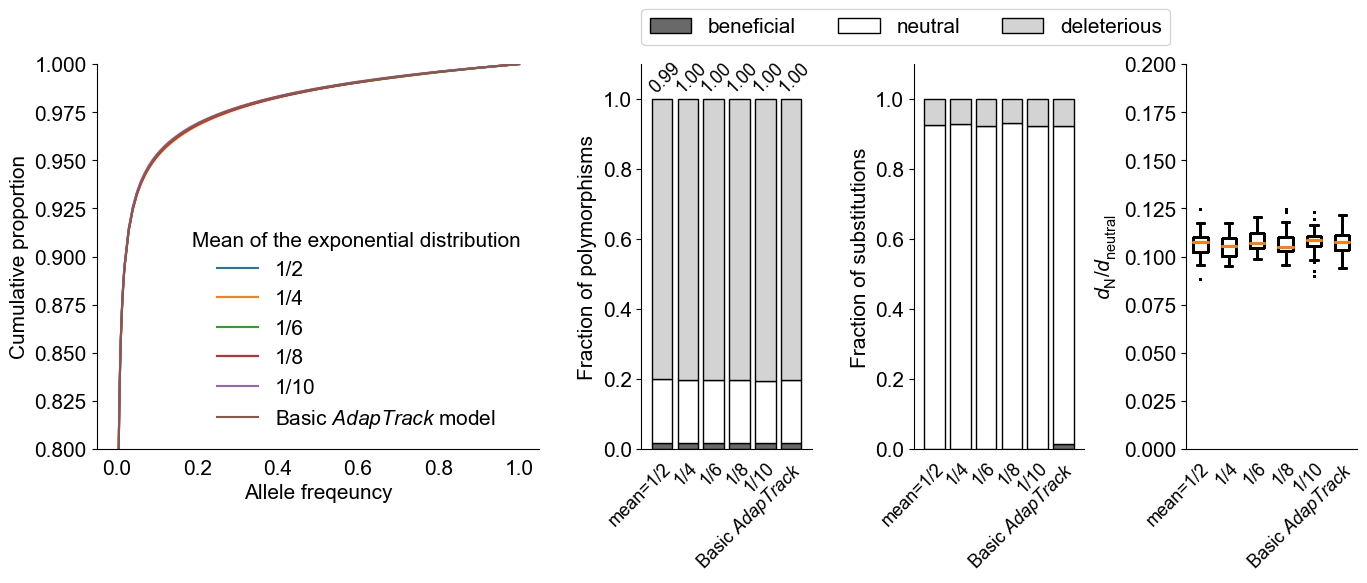

In [22]:
# Figure S3 i-l

label_dict = {
    'quasi_lambda2':'1/2',
    'quasi_lambda4':'1/4',
    'quasi_lambda6':'1/6',
    'quasi_lambda8':'1/8',
    'quasi_lambda10':'1/10',
    'quasi_pop10000':'Basic $\mathit{AdapTrack}$ model',
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
ax3= fig.add_subplot(gs[0, 3])
ax4= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['mean=1/2','1/4','1/6','1/8','1/10','Basic $\mathit{AdapTrack}$']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_lambda2','quasi_lambda4','quasi_lambda6',
                'quasi_lambda8','quasi_lambda10','quasi_pop10000']:
    ax1.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax1.legend(title='Mean of the exponential distribution',framealpha=0)
ax1.set_xlabel('Allele freqeuncy',fontsize=15)
ax1.set_ylabel('Cumulative proportion',fontsize=15)
ax1.set_ylim(0.8,1)

for idx,i in enumerate([24,25,26,27,28,18]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax2.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
        
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax2.text(
        x=idx+0.1,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,size=13
    )
    
ax2.set_xticks([0,1,2,3,4,5])
ax2.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax2.set_ylabel('Fraction of polymorphisms')
ax2.legend(loc=[0,1.05], ncol=3)
ax2.set_ylim(0,1.1)
ax2.set_xlim(-0.8,5.8)

ax3.set_xticks([0,1,2,3,4,5])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax3.set_ylabel('Fraction of substitutions')
ax3.set_ylim(0,1.1)
ax3.set_xlim(-0.8,5.8)

for rep in range(1,31):
    ax4.boxplot(
        plt_df.loc[[24,25,26,27,28,18],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,widths=0.5,
        flierprops = flierprops
    )
ax4.set_xticks([1,2,3,4,5,6])
ax4.set_ylim(0,0.2)
ax4.set_xlim(0.5,6.5)
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax4.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$',fontsize=15)

plt.tight_layout()
#plt.savefig(f'Figures/FigS3_5.pdf',bbox_inches='tight')

/tmp/ipykernel_392294/2914022715.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


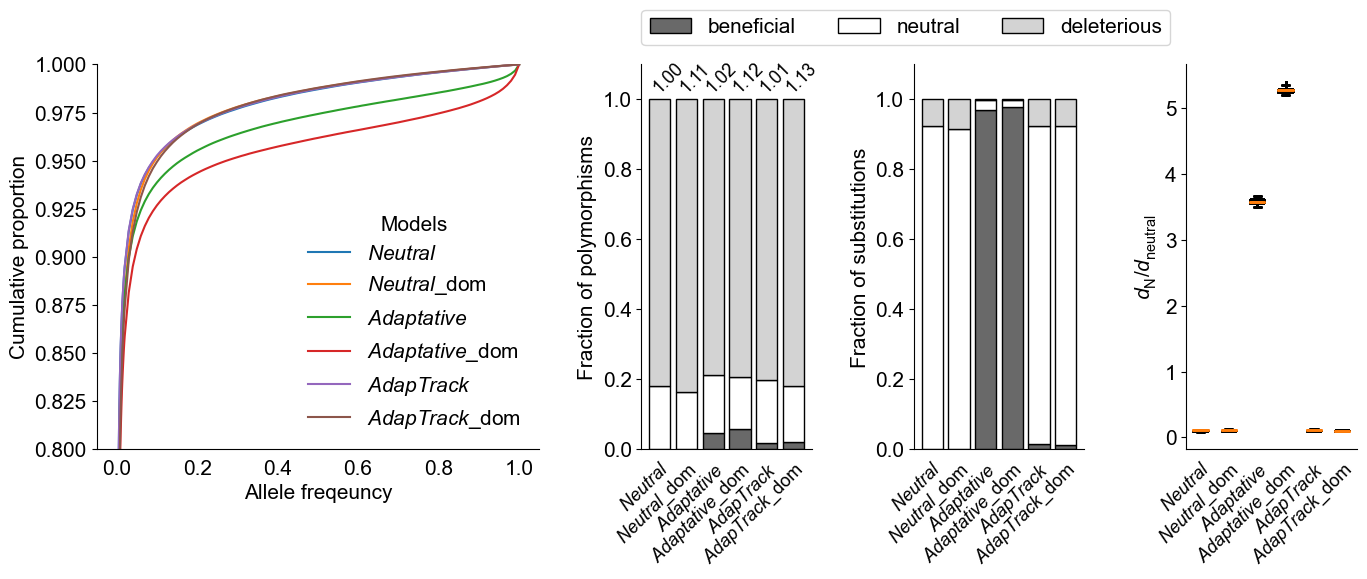

In [20]:
# Figure S3 m-p

label_dict = {
    'Neutral':'$\mathit{Neutral}$',
    'Neutral_dom':'$\mathit{Neutral}$_dom',
    'Adaptive':'$\mathit{Adaptative}$',
    'Adaptive_dom':'$\mathit{Adaptative}$_dom',
    'quasi_pop10000':'$\mathit{AdapTrack}$',
    'quasi_dom':'$\mathit{AdapTrack}$_dom'
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
ax3= fig.add_subplot(gs[0, 3])
ax4= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\mathit{Neutral}$','$\mathit{Neutral}$_dom','$\mathit{Adaptative}$',
             '$\mathit{Adaptative}$_dom','$\mathit{AdapTrack}$','$\mathit{AdapTrack}$_dom']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['Neutral','Neutral_dom','Adaptive','Adaptive_dom','quasi_pop10000','quasi_dom']:
    ax1.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax1.legend(title='Models', framealpha=0)
ax1.set_xlabel('Allele freqeuncy',fontsize=15)
ax1.set_ylabel('Cumulative proportion',fontsize=15)
ax1.set_ylim(0.8,1)

for idx,i in enumerate([1,3,2,4,18,6]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax2.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[1,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax2.text(
        x=idx+0.3,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,size=13
    )

ax2.set_xticks([0,1,2,3,4,5])
ax2.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax2.set_ylabel('Fraction of polymorphisms')
ax2.legend(loc=[0,1.05], ncol=3)
ax2.set_ylim(0,1.1)

ax3.set_xticks([0,1,2,3,4,5])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax3.set_ylabel('Fraction of substitutions')
ax3.set_ylim(0,1.1)

for rep in range(1,31):
    ax4.boxplot(
        plt_df.loc[[1,3,2,4,18,6],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        flierprops = flierprops
    )
ax4.set_xticks([1,2,3,4,5,6])
#ax4.set_ylim(0.05,0.15)
ax4.set_xlim(0.5,6.5)
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax4.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$')

plt.tight_layout()
#plt.savefig(f'Figures/FigS3_3.pdf',bbox_inches='tight')

/tmp/ipykernel_392294/4119852442.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


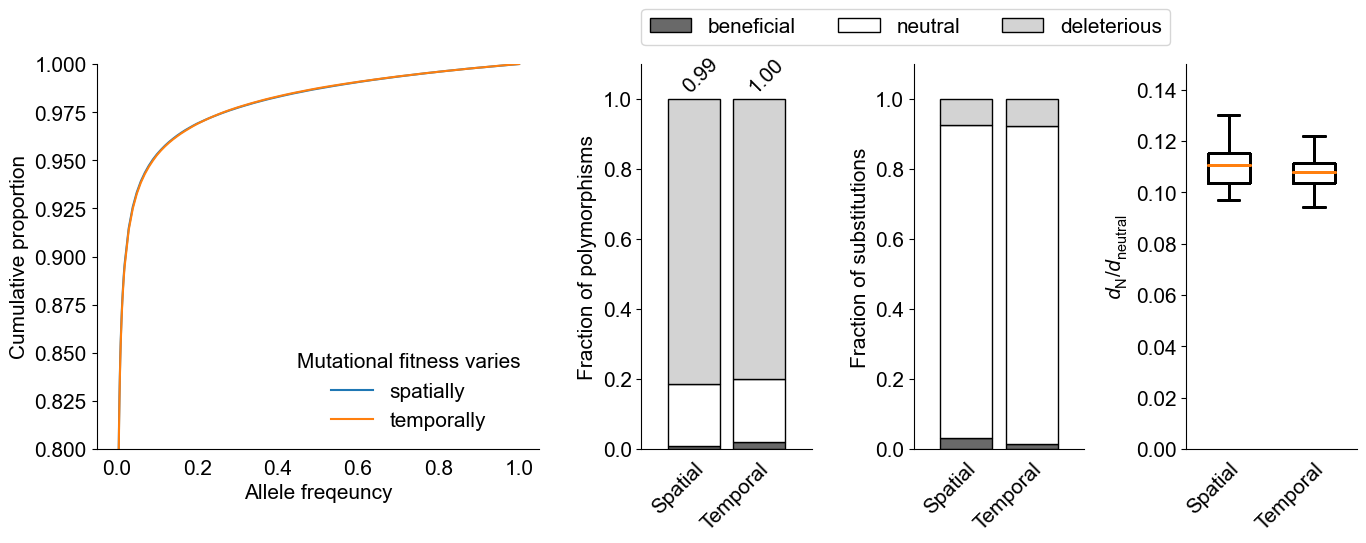

In [21]:
# Figure S9

label_dict = {
    'quasi_stablespace20':'spatially',
    'quasi_pop10000':'temporally'
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
ax3= fig.add_subplot(gs[0, 3])
ax4= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['Spatial','Temporal']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_stablespace20','quasi_pop10000']:
    ax1.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax1.legend(title='Mutational fitness varies',framealpha=0)
ax1.set_xlabel('Allele freqeuncy',fontsize=15)
ax1.set_ylabel('Cumulative proportion',fontsize=15)
ax1.set_ylim(0.8,1)

for idx,i in enumerate([5,18]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax2.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax2.text(
        x=idx+0.1,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45
    )
    
ax2.set_xticks([0,1])
ax2.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax2.set_ylabel('Fraction of polymorphisms')
ax2.legend(loc=[0,1.05], ncol=3)
ax2.set_ylim(0,1.1)
ax2.set_xlim(-0.8,1.8)

ax3.set_xticks([0,1])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax3.set_ylabel('Fraction of substitutions')
ax3.set_ylim(0,1.1)
ax3.set_xlim(-0.8,1.8)

for rep in range(1,31):
    ax4.boxplot(
        plt_df.loc[[5,18],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,widths=0.5,
        flierprops = flierprops
    )
ax4.set_xticks([1,2])
ax4.set_ylim(0,0.15)
ax4.set_xlim(0.5,2.5)
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax4.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$',fontsize=15)

plt.tight_layout()
#plt.savefig(f'Figures/FigS3_4.pdf',bbox_inches='tight')